## Final sprint:
At the end of the last sprint I indicated 2 problems that happered the full workability of this worksheet. 
1) stack overflow from python / data limits from jupyter.
2) problems with visualization.

1) I belief this problem is due to the inability of python to optimize their tail recursions. this means that after a certain limit their is a stackover from the language itself.
Combined with this I should have spread the load of the calculation over several functions instead of putting it all in one. 
2) The problem of visualization has not been clearly solved. But I belief I have found a work around. 

below you will find the reworked functions.

In [1]:
# importing pandas for the dataframes
import pandas as pd
import matplotlib.pyplot as plt
import math as math

# output to notebook
%matplotlib inline

#importing sys to increase the recursion limit, 
import resource, sys
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(10**6)

#importing the higher function reduce for a specific part of the code
from functools import reduce


#the proces ID to get into bigquery
projectid = "vast-art-167309"

In [2]:

class acceleration:    
                               
    def bigquery_adjusted (self, vehicle):
        """specific function which targets the bigquery database and reformats it"""
        car_list = []
        #the query to bigquery
        query_df = pd.read_gbq("select timestamp, value, vehicle from [headingon_params.speed_obd] where vehicle = '%s' order by timestamp asc" %(vehicle), projectid)
        end_row = query_df['timestamp'].count() -1
        return self.filter_function_forloop(vehicle, end_row, query_df, car_list)

    def filter_function_forloop (self,vehicle, end, dataframe, car_list):
        """This function filters the data which is pulled by the f(bigquery_adjusted) and filters out the blocks that will be used
            by f(core_function_forloop) """
        for row in range (0, end):
            if dataframe.iloc[row,1] == 0.0:
                row_add = row + 1
                if dataframe.iloc[row_add,1] != 0.0:
                    row_2_added = row_add + 1
                    if dataframe.iloc[row_2_added,1] != 0.0:
                        row_3_added = row_2_added + 1
                        if dataframe.iloc[row_3_added,1] != 0.0:
                            self.core_function_forloop(vehicle, row, dataframe, car_list)
                        else:
                            pass
                    else:
                        pass
                else:
                    pass
            else:
                pass
        return car_list
            
    def core_function_forloop(self,vehicle, row, dataframe, car_list):
        """this function calculates the acceleration over a 3 second window"""
        temp_list = []
        timestamp = dataframe.iat[row,0]
        for i in range(1,4):
            temp_row = row + i
            temp_list.append(dataframe.iat[temp_row,1])
        average_km = (reduce((lambda x, y: x+y), temp_list) / 3) 
        car_list.append({'timestamp': timestamp, 'value': average_km, 'vehicle': vehicle})
        return

###########################################################################################################################
####This part of the class acceleration is my coded version of the Local Outlier Factor ###################################
###########################################################################################################################
    
    
    def selecting_k_distance_function(self, dataframe, k, car):
        """Main function under which all other function for determining the LOF factor is placed"""
        #determines the length of the dataframe
        row_dataframe = dataframe['timestamp'].count()
        k_value = k + 1
        dataframe= dataframe.round(1)
        #counter which will be used as x coordinate
        dataframe['counter'] = range(len(dataframe))
        #unique id with x and y coordinates
        dataframe['unique_id'] = list(zip(dataframe['counter'], dataframe['value']))
        column_layout = ['unique_id']
        column_values = []
        observation_values = []
        #builds the appropriate dataframe size according to the inputs given
        for i in range(1, k_value):
            dataframe['value_k' + str(i)] = 1000
            column_layout.append('value_k' + str(i))
            column_values.append('value_k' + str(i))
            dataframe['observation_k' + str(i)] = -1
            column_layout.append('observation_k' + str(i))
            observation_values.append('observation_k' + str(i))
        dataframe = dataframe[column_layout]
        #calculating the Local reach density
        for i in range(1, k_value):
            self.all_columns_function(0,dataframe, i)
        dataframe['sum for LRD'] =  dataframe[column_values].sum(axis=1)
        dataframe['LRD'] = 1/(dataframe['sum for LRD']/k)
        
        observations =[]
        # not sure to be happy or worried about this fact that i can do a for-loop and listcomprehension simultaneously
        # reason for this choice: a list comprehension does not change data once '=' is reached, at least that is what my debugger insinuates 
        for i in dataframe[observation_values]:
            observations.append('check_'+ i)
            dataframe['check_'+ i] = [dataframe.loc[dataframe.loc[j,i], 'LRD'] for j in range(row_dataframe)]
        dataframe['LOF'] = (dataframe[observations].sum(axis=1)/k)/dataframe.loc[:,'LRD']
        
        inliers_dataframe = dataframe[dataframe['LOF'] < 1.6]
        outliers_dataframe = dataframe[dataframe['LOF'] > 1.5]
        
        inliers_dataframe['counter'], inliers_dataframe['value'] = zip(*inliers_dataframe['unique_id'])
        inliers_dataframe.plot.scatter(x='counter', y='value', title=str(car) + " WITHOUT outliers")
        
        inliers_dataframe.hist(column='value', normed=1)

    
    def all_columns_function(self, base_row,dataframe, k):
        """this function goes composes all the necessary columns"""
        row_dataframe = (dataframe['unique_id'].count() - 1) 
        if base_row > row_dataframe:
            return
        row_list_seq = list(range((base_row+1), (row_dataframe + 1)))
        row_list_seq.extend(range(base_row))
        for i in row_list_seq:
            self.min_function(base_row,i ,row_dataframe, dataframe, k)   
        base_row +=1
        return self.all_columns_function(base_row,dataframe, k)       
        
    def min_function(self,base_row, next_row,row_dataframe,dataframe, k):
        """This function together with f(euclides_function) determines the lowest euclidean value and places it in the correc
            column"""
        if k > 1:
            other_column_value = dataframe.loc[base_row,('value_k' + str(k-1))]
            current_value = dataframe.loc[base_row, ('value_k' + str(k))]
            temp_value = self.euclides_function(base_row,next_row, row_dataframe, dataframe)
            if (temp_value < current_value and temp_value > other_column_value):
                dataframe.loc[base_row,('value_k' + str(k))] = temp_value
                coordinate_of_value = dataframe.iloc[next_row, 0]
                coordinate_column = 'observation_k' + str(k)
                dataframe.set_value(base_row,coordinate_column,coordinate_of_value[0])
            else:
                pass
        else:
            current_value = dataframe.loc[base_row, ('value_k' + str(k))]
            temp_value = self.euclides_function(base_row,next_row, row_dataframe, dataframe)
            if temp_value < current_value:
                dataframe.loc[base_row,('value_k' + str(k))] = temp_value
                coordinate_of_value = dataframe.iloc[next_row, 0]
                coordinate_column = 'observation_k' + str(k)
                dataframe.set_value(base_row,coordinate_column,coordinate_of_value[0])
            else:
                pass      
    
    
      #the formula to calculate the euclidean distance between two point (as the crows fly)
    def euclides_function (self, base_row, next_row, row_dataframe,dataframe):
        """calculates either the euclidean value or the straight line depending on the circumstance"""
        tuple_base = dataframe.iloc[base_row,0]
        tuple_next = dataframe.iloc[next_row,0]  
        
        if tuple_base[1] == tuple_next[1]:
            euclide_distance = abs(tuple_base[0]-tuple_next[0])
            return euclide_distance
        else:
            euclide_distance = math.sqrt(math.pow((tuple_base[0] - tuple_next[0]),2) + 
                                         math.pow((tuple_base[1] - tuple_next[1]),2))
            return euclide_distance
        
        
def everything_together (list_vehicle, k_value):
    """retrieving the data from the bigquery, calculating the acceleration, with the k value"""
    for car in list_vehicle:
        car_present = acceleration()
        car_present.dataframeALL = pd.DataFrame(car_present.bigquery_adjusted(car))
        car_present.dataframeALL['counter'] = range(len(car_present.dataframeALL))
        car_present.dataframeALL.plot.scatter(x='counter', y='value', title=str(car) + " with outliers")
        car_present.dataframe_validation = car_present.dataframeALL[(car_present.dataframeALL['value'] < 1)]
        print(car_present.dataframe_validation)
        car_present.selecting_k_distance_function(car_present.dataframeALL,k_value, car)
    return   

### list of cars:
The above has been individually tested and works as expected. Bellow we have composed a new list of all the names of the cars. I am using the old names since the new names seem to have some problems in their unique identification keys.

also, we will use a k of 7. I have done several tests and the value of k has a significant influence on the outliers up until a point afterwhich it starts to plateau. However, as indictated in my previous sprint I have not found any clear writting on *which* k is best for the amount of observations being used. So I am going for k=7 though the program has been written in a way that you can change the k arbitrarily. Which I have done bellow for comvenience. But feel free to experiment.

In [9]:
cars_list = [ 'car1', 'car2', 'car3', 'car4', 'car5', 'car6', 'car7']

#cars_list=['4T3BK3BB7AU032766', 'KMHLB8ULDU069747', 'TMBAA25J883113476', 'TSMMZC21S00134117', 
#           'WDD1760082J557012', 'WVWZZZ3CZDE025430', 'YV1MW84F1B2624570']

Requesting query... ok.
Job ID: job_WSEQf6FhnPfYUYPIfe9GqSiKewYw
Query running...
Query done.
Cache hit.

Retrieving results...
Got 63829 rows.

Total time taken 4.48 s.
Finished at 2017-11-27 15:01:51.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_UmIYfosEVKgjnswQQH_CVsewx-3k
Query running...
Query done.
Cache hit.

Retrieving results...
Got 14042 rows.

Total time taken 1.57 s.
Finished at 2017-11-27 15:02:27.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_l4IMfGLSTEsSm_iQ-aDpjVb944L2
Query running...
Query done.
Cache hit.

Retrieving results...
Got 58361 rows.

Total time taken 3.36 s.
Finished at 2017-11-27 15:02:34.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_4CuhR-hwLOg7XFYBZZkS-sA6yJGC
Query running...
Query done.
Processed: 30.2 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 40% done. Elapsed 13.66 s.
  Got page: 2; 80% done. Elapsed 18.48 s.
  Got page: 3; 100% done. Elapsed 21.14 s.
Got 248905 rows.

Total time taken 23.58 s.
Finished at 2017-11-27 15:03:31.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_7XjLOq4hkZtqRbMr_ky1j8R9gmcq
Query running...
Query done.
Cache hit.

Retrieving results...
Got 68882 rows.

Total time taken 4.4 s.
Finished at 2017-11-27 15:09:25.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_fLLMQqiqLUXjcOz4F6aG9_yYuq7i
Query running...
Query done.
Processed: 30.2 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 95% done. Elapsed 12.04 s.
  Got page: 2; 100% done. Elapsed 12.61 s.
Got 105017 rows.

Total time taken 13.53 s.
Finished at 2017-11-27 15:09:54.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_cKsCglusZ-3KkEgiCO2mMv2_UkFY
Query running...
Query done.
Cache hit.

Retrieving results...
Got 91146 rows.

Total time taken 5.54 s.
Finished at 2017-11-27 15:10:28.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alexander_chen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


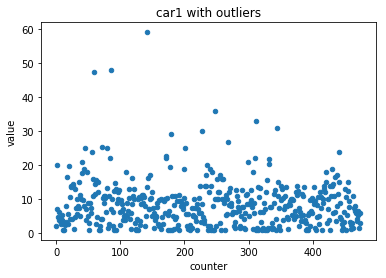

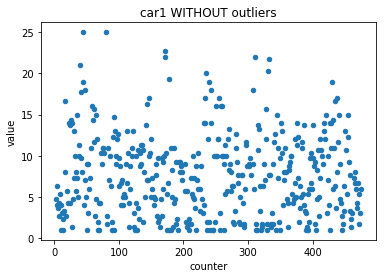

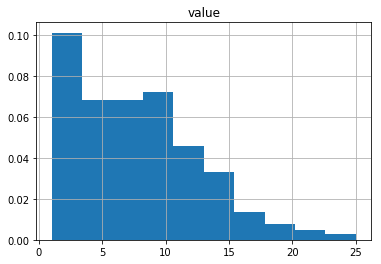

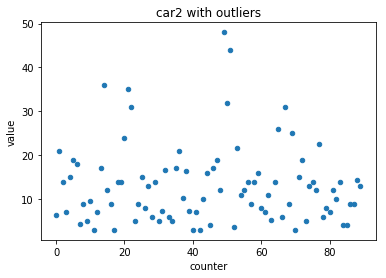

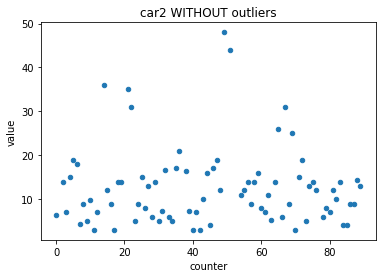

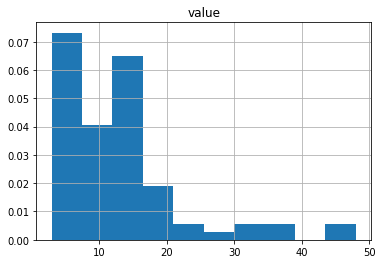

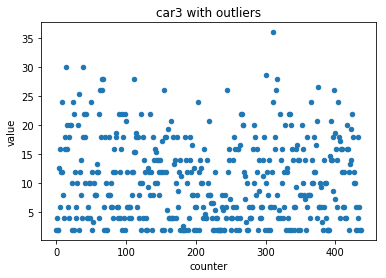

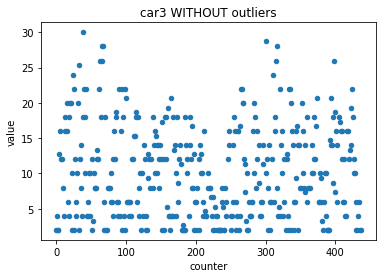

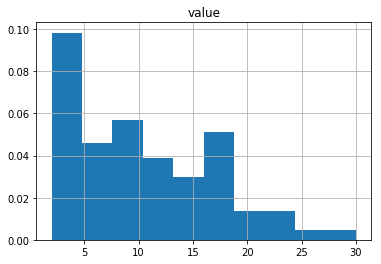

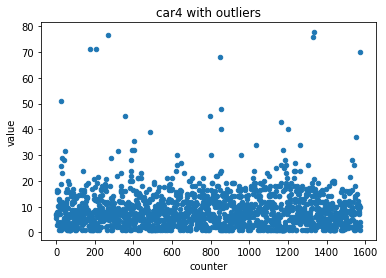

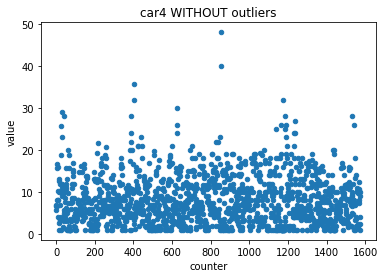

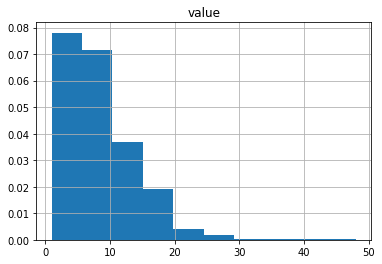

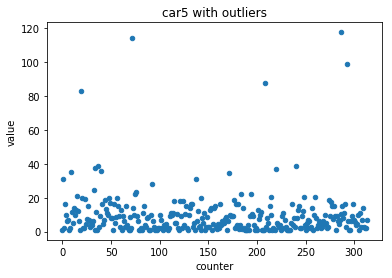

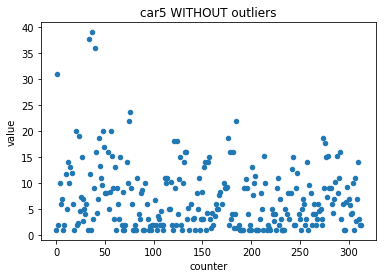

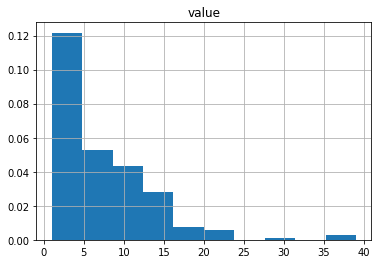

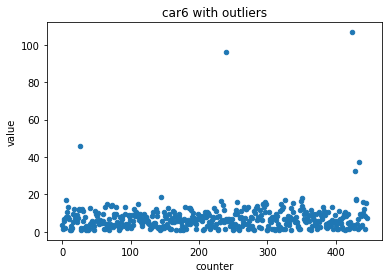

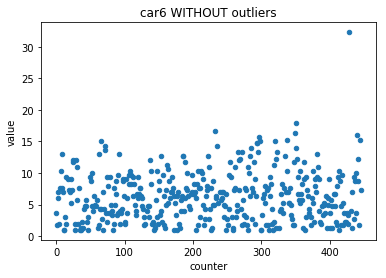

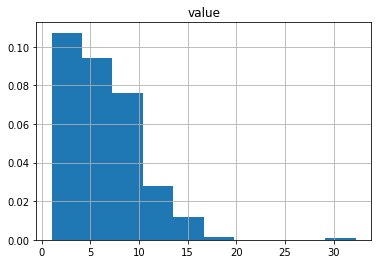

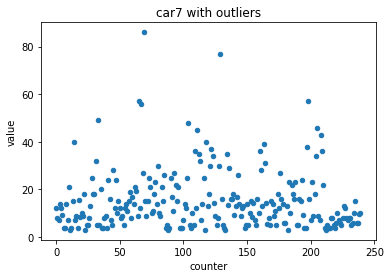

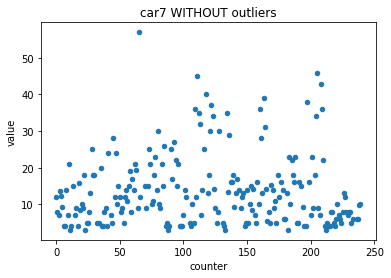

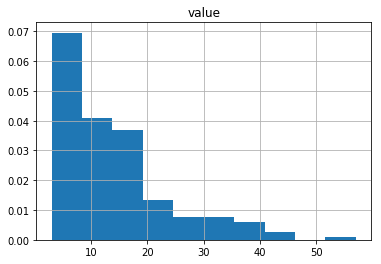

In [10]:
everything_together(cars_list, 3)

Requesting query... ok.
Job ID: job_hTSOSeibXgoqViCb5ku3xFbPBW7w
Query running...
Query done.
Cache hit.

Retrieving results...
Got 63829 rows.

Total time taken 4.31 s.
Finished at 2017-11-27 16:01:55.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_jdr7G23wiLWp6Wxv_R2jX3lB7xQ_
Query running...
Query done.
Cache hit.

Retrieving results...
Got 14042 rows.

Total time taken 1.65 s.
Finished at 2017-11-27 16:02:48.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_pJzKENrwOMj39QBpBQgTEEd3E29Y
Query running...
Query done.
Cache hit.

Retrieving results...
Got 58361 rows.

Total time taken 3.51 s.
Finished at 2017-11-27 16:02:56.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_VRTtTiDJTDCXwXiS1JIuvUAU4ZLV
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 80% done. Elapsed 9.68 s.
  Got page: 3; 100% done. Elapsed 12.19 s.
Got 248905 rows.

Total time taken 14.34 s.
Finished at 2017-11-27 16:03:56.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_i7GwXqklCNz5rmyDQCcvZ5Ee13oj
Query running...
Query done.
Cache hit.

Retrieving results...
Got 68882 rows.

Total time taken 4.11 s.
Finished at 2017-11-27 16:12:21.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job__RfTLBcov2b6JyCy0HWvkXzWXEuz
Query running...
Query done.
Cache hit.

Retrieving results...
Got 105017 rows.

Total time taken 6.25 s.
Finished at 2017-11-27 16:12:52.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_QVapSRWkgPzfNXyGmGd2QfCg5waQ
Query running...
Query done.
Cache hit.

Retrieving results...
Got 91146 rows.

Total time taken 5.58 s.
Finished at 2017-11-27 16:13:44.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alexander_chen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


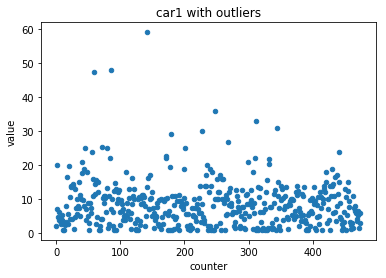

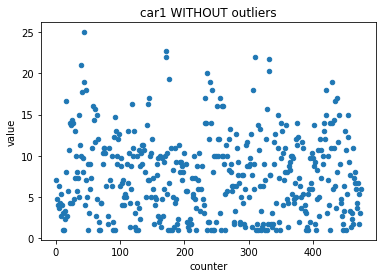

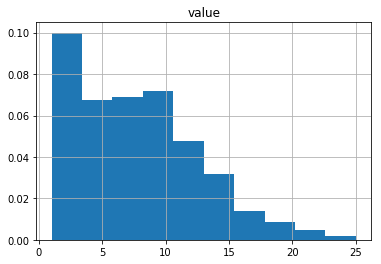

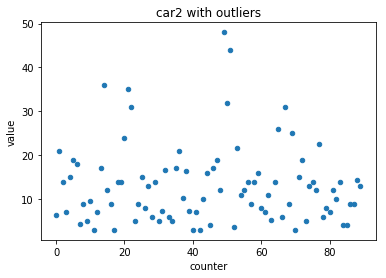

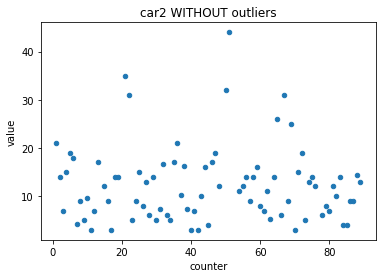

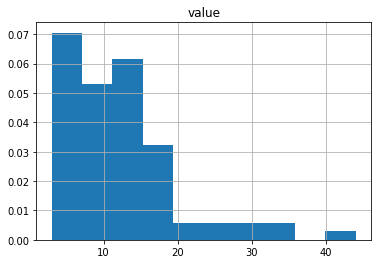

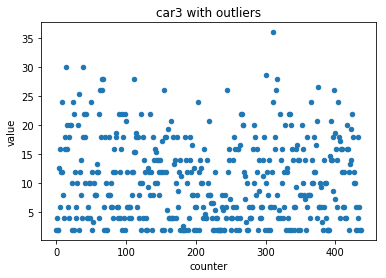

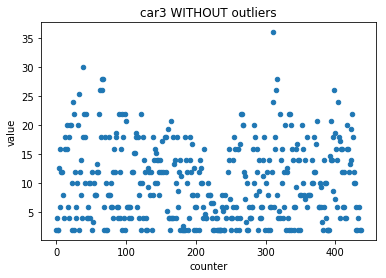

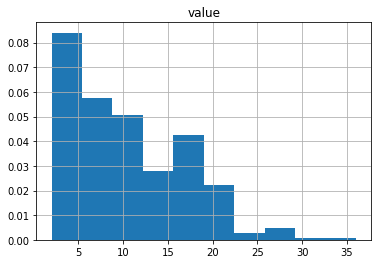

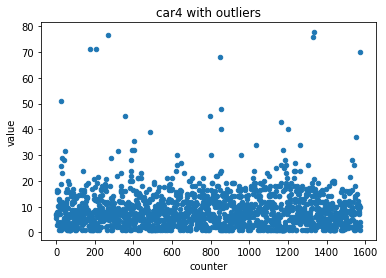

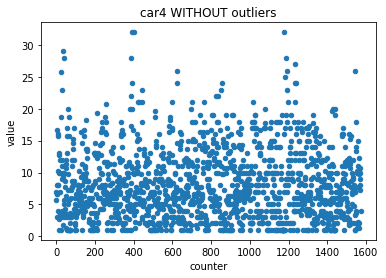

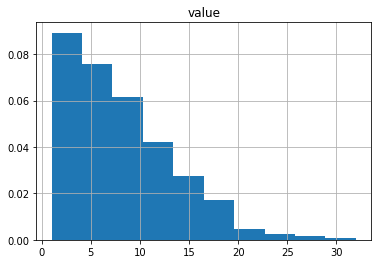

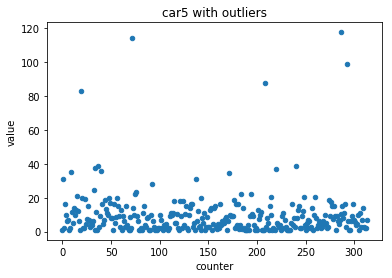

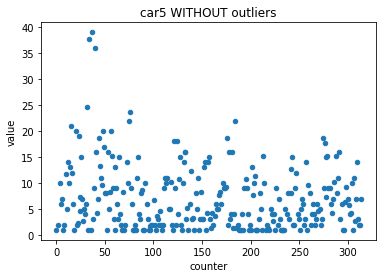

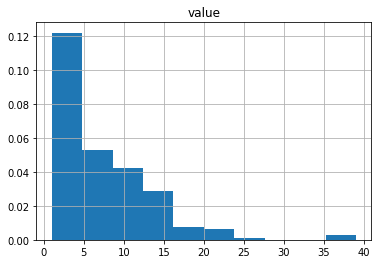

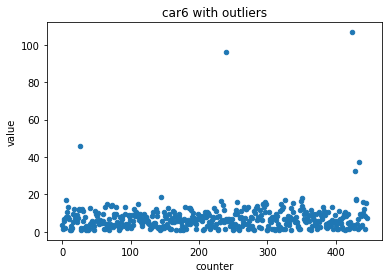

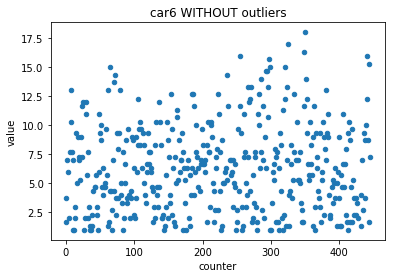

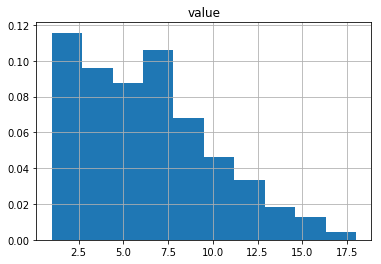

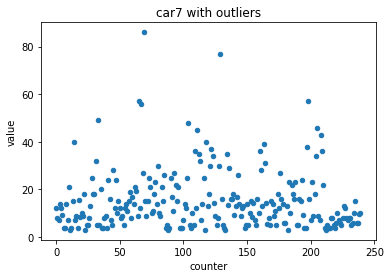

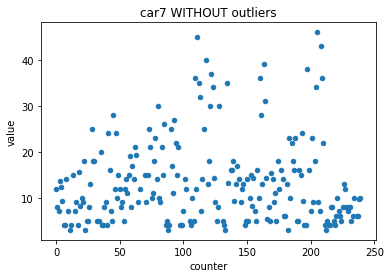

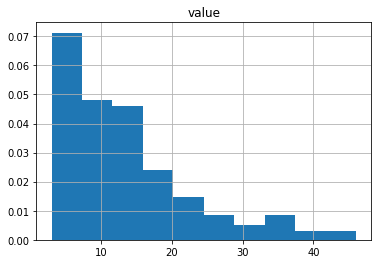

In [14]:
everything_together(cars_list, 5)

Requesting query... ok.
Job ID: job_97oduVlA-Ymnoe9jn2F2HTOm_rAW
Query running...
Query done.
Cache hit.

Retrieving results...
Got 63829 rows.

Total time taken 4.74 s.
Finished at 2017-11-27 15:23:20.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_Tk-B6Uf29DQr97YMyi47PwUXzkDF
Query running...
Query done.
Cache hit.

Retrieving results...
Got 14042 rows.

Total time taken 1.49 s.
Finished at 2017-11-27 15:24:34.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_ZTl9SpHo_8uHMj9kBZGLUjylgWdw
Query running...
Query done.
Cache hit.

Retrieving results...
Got 58361 rows.

Total time taken 3.79 s.
Finished at 2017-11-27 15:24:43.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_CFQyPcgereAUOwSCrTBnjCYZRdcG
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 80% done. Elapsed 8.43 s.
  Got page: 3; 100% done. Elapsed 10.57 s.
Got 248905 rows.

Total time taken 12.76 s.
Finished at 2017-11-27 15:26:00.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_JCkLcOsMoRPcz5tH5oBB4pM9N6lD
Query running...
Query done.
Cache hit.

Retrieving results...
Got 68882 rows.

Total time taken 3.52 s.
Finished at 2017-11-27 15:37:57.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_nU_X-A1_7TbOJxsPGSd3IVLAzrw0
Query running...
Query done.
Cache hit.

Retrieving results...
Got 105017 rows.

Total time taken 6.44 s.
Finished at 2017-11-27 15:38:39.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_5W8LOagraMVnLekWYi9duwhMoREE
Query running...
Query done.
Cache hit.

Retrieving results...
Got 91146 rows.

Total time taken 6.04 s.
Finished at 2017-11-27 15:39:48.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alexander_chen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


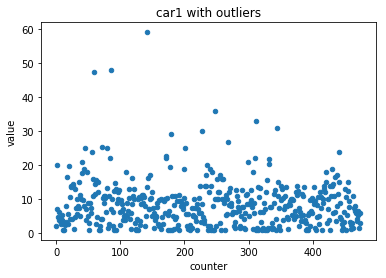

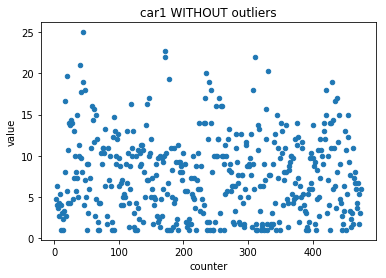

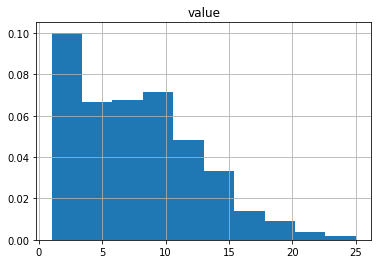

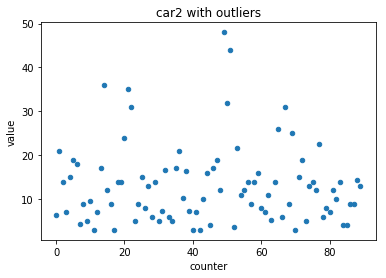

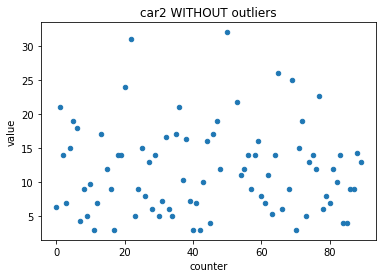

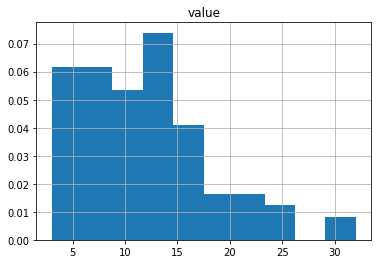

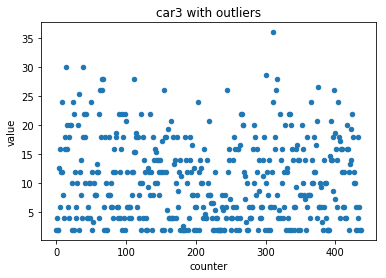

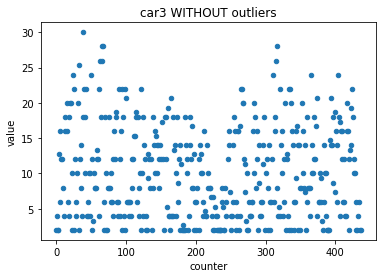

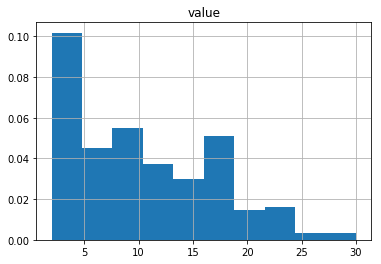

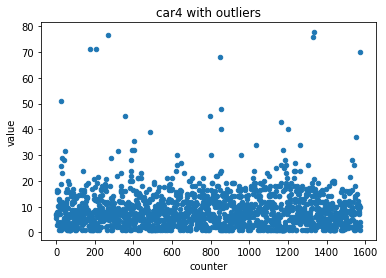

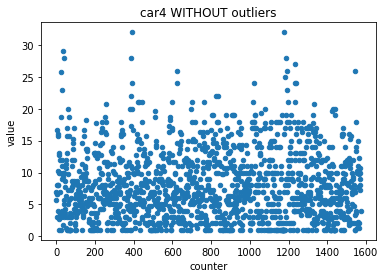

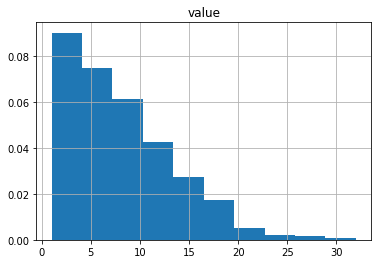

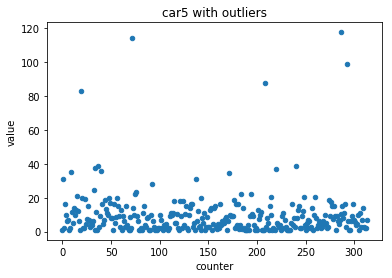

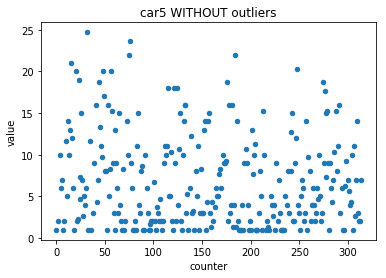

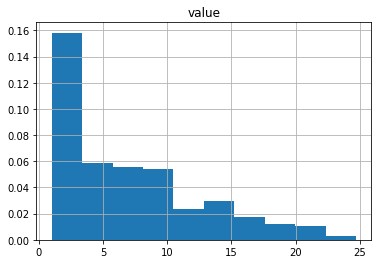

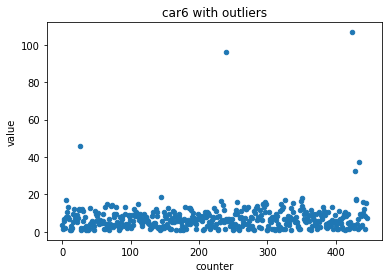

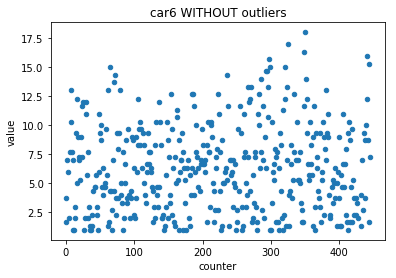

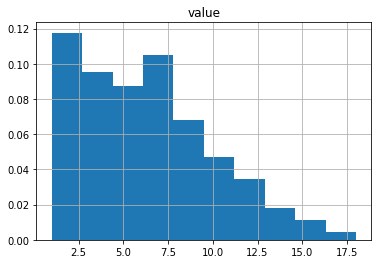

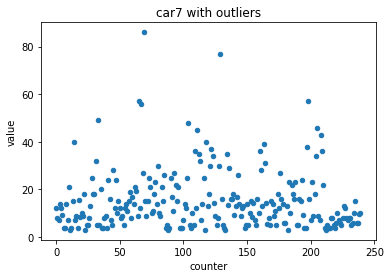

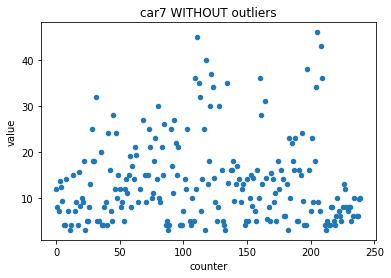

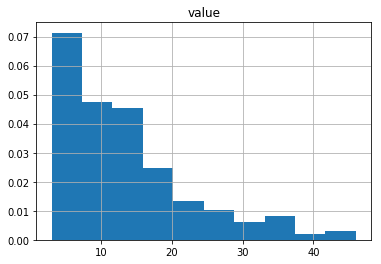

In [12]:
everything_together(cars_list, 7)

Requesting query... ok.
Job ID: job_hLDfJNIzTy2j7SvzAWVOLbKs7rdr
Query running...
Query done.
Cache hit.

Retrieving results...
Got 63829 rows.

Total time taken 4.12 s.
Finished at 2017-11-27 15:40:18.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_or-jZdTZwPOkrWwR4jT6eULq7OcQ
Query running...
Query done.
Cache hit.

Retrieving results...
Got 14042 rows.

Total time taken 1.38 s.
Finished at 2017-11-27 15:41:55.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_K0mp7L02K0wTrWGkuJ_y8RieMtNj
Query running...
Query done.
Cache hit.

Retrieving results...
Got 58361 rows.

Total time taken 3.59 s.
Finished at 2017-11-27 15:42:05.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_7HiWyrdSXsjqbRtpHyo3aW49a7PH
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 80% done. Elapsed 8.72 s.
  Got page: 3; 100% done. Elapsed 11.13 s.
Got 248905 rows.

Total time taken 13.32 s.
Finished at 2017-11-27 15:43:41.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_zvQRe1BfDPcrfYkQwLh31TVc_GLo
Query running...
Query done.
Cache hit.

Retrieving results...
Got 68882 rows.

Total time taken 4.67 s.
Finished at 2017-11-27 15:58:59.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_nV6J_TuS_wTLTJrXvWZGfyDc_dnU
Query running...
Query done.
Cache hit.

Retrieving results...
Got 105017 rows.

Total time taken 6.11 s.
Finished at 2017-11-27 15:59:50.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Requesting query... ok.
Job ID: job_Rz7xoB4etDlMQiK24x6sok9GTXG6
Query running...
Query done.
Cache hit.

Retrieving results...
Got 91146 rows.

Total time taken 5.1 s.
Finished at 2017-11-27 16:01:19.
Empty DataFrame
Columns: [timestamp, value, vehicle, counter]
Index: []


/home/alexander_chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alexander_chen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


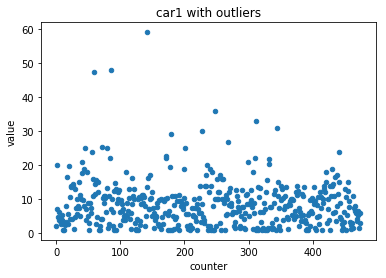

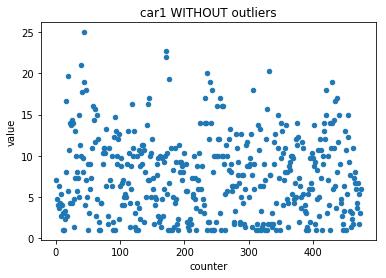

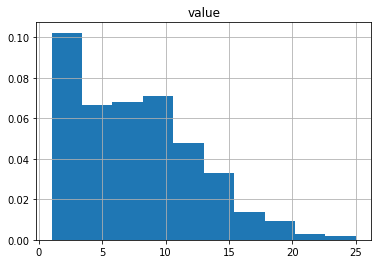

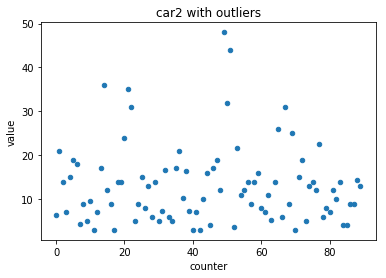

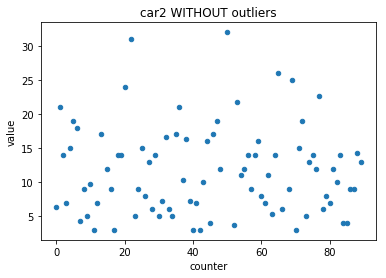

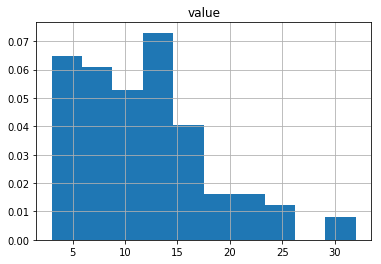

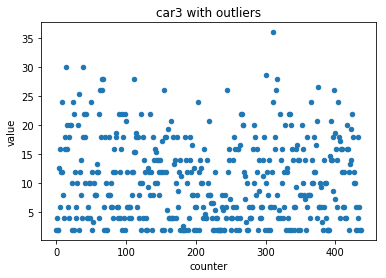

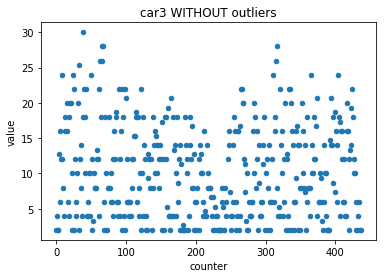

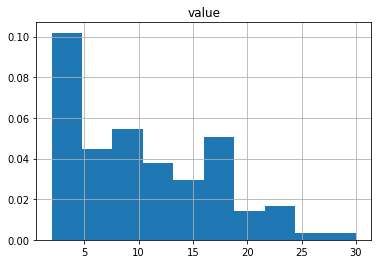

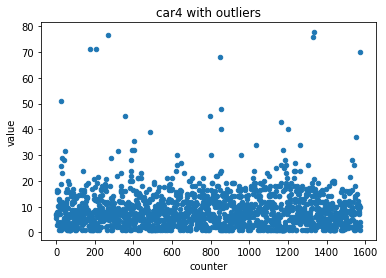

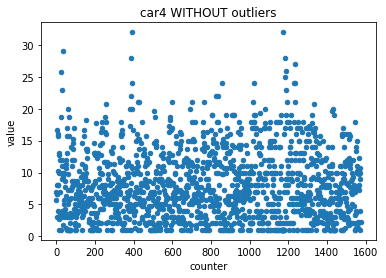

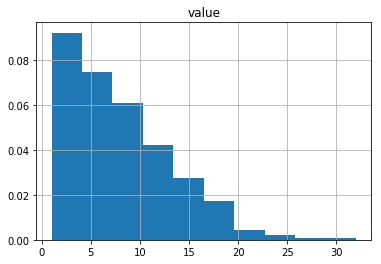

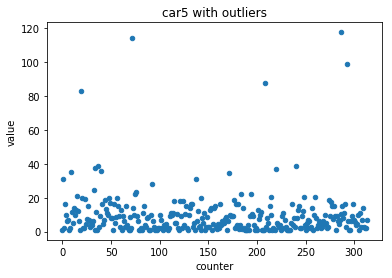

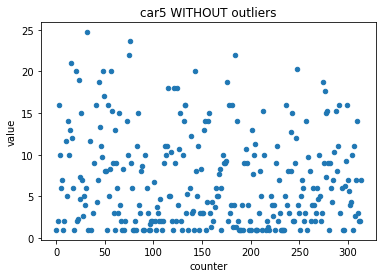

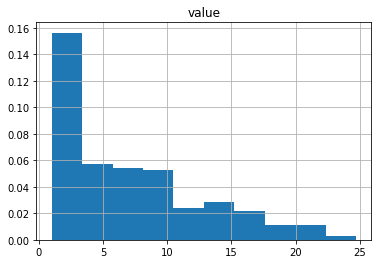

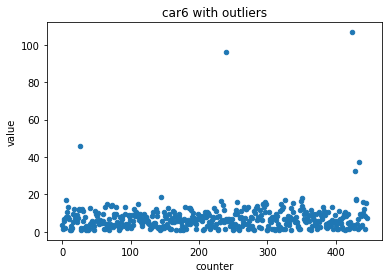

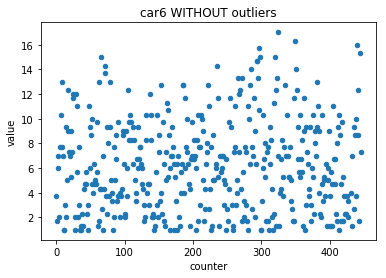

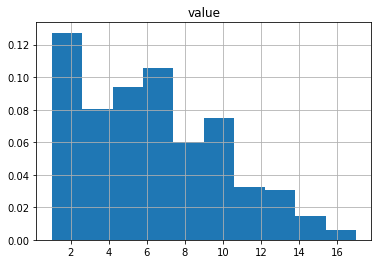

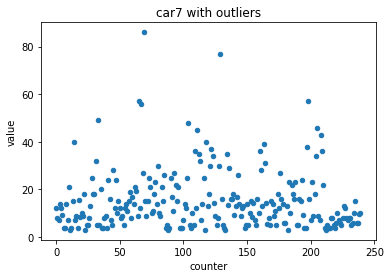

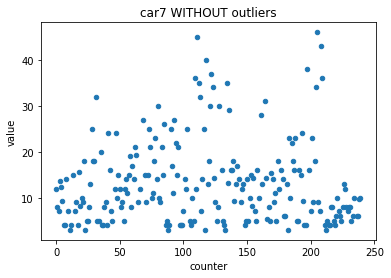

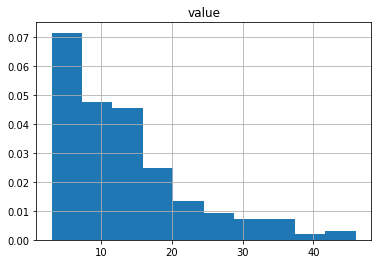

In [13]:
everything_together(cars_list, 9)

### interesting results:
Now what is interesting is the difference between the histograms. For instance car4 of k=9 you see a classic staircase reduction. While if you look at car2 of k=9, you see that the average accelaration is much much higher (frequency tops somewhere around 12 kmh). And finally, looking at car5 of k=9 this person is almost exclusively accelarating at a much lower speed. This could indicate much more congestion driving, where you 'inch forward' most of the time. Looking at the data in this context I would think that the tires of car2 would be more 'worn' than for instance car5 which seems to go extremely cautionly. This is only looking at the data not at the state of the tires etc. 

The next step would be to physically measure the tire 'threading' over time and see if the parameter 'accelaration' is statistically sufficent to explain the rate of tire thread 'wearing'. 